<table class="table table-bordered">
    <tr>
        <th style="text-align:center; vertical-align: middle; width:50%"><img src='https://www.np.edu.sg/images/default-source/default-album/img-logo.png'"></th>
        <th style="text-align:center;"><h1>Deep Learning</h1><h2>Assignment 1 - Food Classification Model (Individual)</h2><h3>AY2023/24 Semester</h3></th>
    </tr>
</table>

In [1]:
# Import the Required Packages
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, Callback

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import os
from PIL import Image
import random

In [5]:
from google.colab import drive

drive.mount('/content/drive')
!ls "/content/drive/My Drive/"
base_dir = "/content/drive/My Drive/Ngee Ann Poly/Deep Learning/ASG1/Images"

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

In [ ]:
from tensorflow.keras.applications import VGG16
img_size = 224

conv_base_1 = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(img_size, img_size, 3))

58889256/58889256 [==============================] - 0s 0us/step


## 1.1 Feature extraction without data augmentation

In [ ]:
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20
img_size = 224

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 7, 7, 512))
    labels = np.zeros(shape=(sample_count, 10))

    generator = datagen.flow_from_directory(
        directory,
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='categorical')

    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base_1.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break

    return features, labels

train_features, train_labels = extract_features(train_dir, 7500)
validation_features, validation_labels = extract_features(validation_dir, 2000)
test_features, test_labels = extract_features(test_dir, 500)

Found 7500 images belonging to 10 classes.
1/1 [==============================] - 0s 31ms/step
Found 2000 images belonging to 10 classes.
1/1 [==============================] - 0s 33ms/step
Found 500 images belonging to 10 classes.
1/1 [==============================] - 0s 22ms/step


In [ ]:
print(train_features.shape)
print(train_labels.shape)

(7500, 25088)
(7500, 10)


In [ ]:
train_features = np.reshape(train_features, (7500, 7 * 7 * 512))
validation_features = np.reshape(validation_features, (2000, 7 * 7 * 512))
test_features = np.reshape(test_features, (500, 7 * 7 * 512))

In [ ]:
model_1 = models.Sequential()
model_1.add(layers.Dense(512, activation='relu', input_shape=(7 * 7 * 512,)))
model_1.add(layers.Dropout(0.5))
model_1.add(layers.Dense(10, activation='softmax'))

model_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 512)               12845568  
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 10)                5130      
                                                                 
Total params: 12850698 (49.02 MB)
Trainable params: 12850698 (49.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model_1.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.Adam(learning_rate=2e-5),
    metrics=['acc']
)

In [ ]:
checkpoint_filepath = '/content/drive/My Drive/Ngee Ann Poly/Deep Learning/ASG1/Code/Step 5/model_1.tf'

model_checkpoint = ModelCheckpoint(
    checkpoint_filepath,
    monitor='val_acc',
    save_best_only=True,
    mode='max',
    verbose=1
)

In [ ]:
history = model_1.fit(train_features, train_labels,
                      epochs=30,
                      batch_size=20,
                      validation_data=(validation_features, validation_labels),
                      callbacks=[model_checkpoint]
                      )

Epoch 1/30
368/375 [============================>.] - ETA: 0s - loss: 1.7879 - acc: 0.3749
Epoch 1: val_acc improved from -inf to 0.58100, saving model to /content/drive/My Drive/Ngee Ann Poly/Deep Learning/ASG1/Code/Step 5/model_1.tf
375/375 [==============================] - 12s 22ms/step - loss: 1.7843 - acc: 0.3757 - val_loss: 1.2979 - val_acc: 0.5810
Epoch 2/30
373/375 [============================>.] - ETA: 0s - loss: 1.2421 - acc: 0.5751
Epoch 2: val_acc improved from 0.58100 to 0.61150, saving model to /content/drive/My Drive/Ngee Ann Poly/Deep Learning/ASG1/Code/Step 5/model_1.tf
375/375 [==============================] - 4s 11ms/step - loss: 1.2421 - acc: 0.5752 - val_loss: 1.1274 - val_acc: 0.6115
Epoch 3/30
371/375 [============================>.] - ETA: 0s - loss: 1.0292 - acc: 0.6530
Epoch 3: val_acc improved from 0.61150 to 0.65250, saving model to /content/drive/My Drive/Ngee Ann Poly/Deep Learning/ASG1/Code/Step 5/model_1.tf
375/375 [==============================] - 4

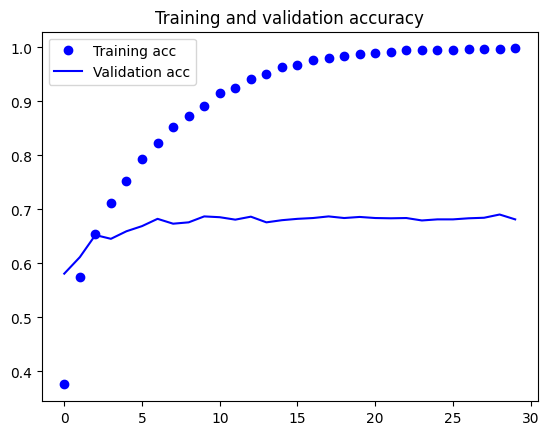

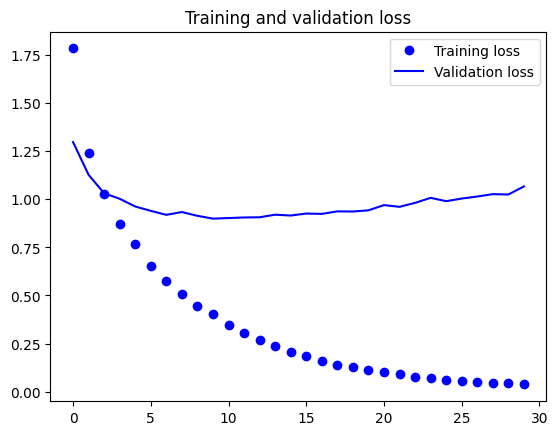

In [ ]:
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# Load the model
model_1 = keras.models.load_model('/content/drive/My Drive/Ngee Ann Poly/Deep Learning/ASG1/Code/Step 5/model_1.tf')

evaluation_results = model_1.evaluate(test_features, test_labels)

print("Test Loss:", evaluation_results[0])
print("Test Accuracy:", evaluation_results[1])

16/16 [==============================] - 0s 6ms/step - loss: 1.0366 - acc: 0.6880
Test Loss: 1.036625862121582
Test Accuracy: 0.6880000233650208


In [ ]:
predictions = model_1.predict(test_features)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(test_labels, axis=1)

class_report = classification_report(true_labels, predicted_labels)
print("Classification Report:")
print(class_report)

16/16 [==============================] - 0s 3ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.66      0.66        50
           1       0.85      0.78      0.81        50
           2       0.58      0.58      0.58        50
           3       0.58      0.66      0.62        50
           4       0.79      0.76      0.78        50
           5       0.65      0.68      0.67        50
           6       0.58      0.58      0.58        50
           7       0.64      0.72      0.68        50
           8       0.66      0.58      0.62        50
           9       0.94      0.88      0.91        50

    accuracy                           0.69       500
   macro avg       0.69      0.69      0.69       500
weighted avg       0.69      0.69      0.69       500



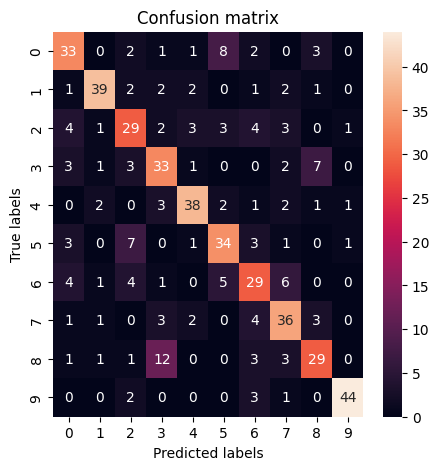

In [ ]:
confusion_matrix_1 = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(5,5))
sns.heatmap(confusion_matrix_1, annot=True, fmt='d')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion matrix')
plt.show()

In [ ]:
model_2 = models.Sequential()
model_2.add(layers.Dense(256, activation='relu', input_shape=(7 * 7 * 512,)))
model_2.add(layers.Dropout(0.5))
model_2.add(layers.Dense(10, activation='softmax'))

model_2.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 256)               6422784   
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_13 (Dense)            (None, 10)                2570      
                                                                 
Total params: 6425354 (24.51 MB)
Trainable params: 6425354 (24.51 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model_2.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.Adam(learning_rate=2e-5),
    metrics=['acc']
)

In [ ]:
checkpoint_filepath = '/content/drive/My Drive/Ngee Ann Poly/Deep Learning/ASG1/Code/Step 5/model_2.tf'

model_checkpoint = ModelCheckpoint(
    checkpoint_filepath,
    monitor='val_acc',
    save_best_only=True,
    mode='max',
    verbose=1
)

In [ ]:
history = model_2.fit(train_features, train_labels,
                      epochs=30,
                      batch_size=20,
                      validation_data=(validation_features, validation_labels),
                      callbacks=[model_checkpoint]
                      )

Epoch 1/30
370/375 [============================>.] - ETA: 0s - loss: 1.9415 - acc: 0.3193
Epoch 1: val_acc improved from -inf to 0.53100, saving model to /content/drive/My Drive/Ngee Ann Poly/Deep Learning/ASG1/Code/Step 5/model_2.tf
375/375 [==============================] - 5s 11ms/step - loss: 1.9378 - acc: 0.3204 - val_loss: 1.4615 - val_acc: 0.5310
Epoch 2/30
375/375 [==============================] - ETA: 0s - loss: 1.4055 - acc: 0.5297
Epoch 2: val_acc improved from 0.53100 to 0.59100, saving model to /content/drive/My Drive/Ngee Ann Poly/Deep Learning/ASG1/Code/Step 5/model_2.tf
375/375 [==============================] - 4s 11ms/step - loss: 1.4055 - acc: 0.5297 - val_loss: 1.2348 - val_acc: 0.5910
Epoch 3/30
374/375 [============================>.] - ETA: 0s - loss: 1.1826 - acc: 0.6095
Epoch 3: val_acc improved from 0.59100 to 0.62900, saving model to /content/drive/My Drive/Ngee Ann Poly/Deep Learning/ASG1/Code/Step 5/model_2.tf
375/375 [==============================] - 3s

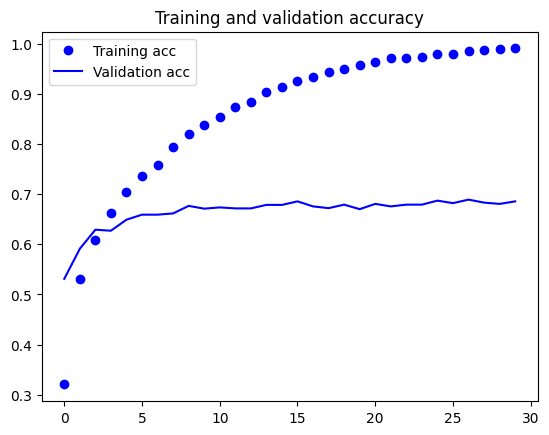

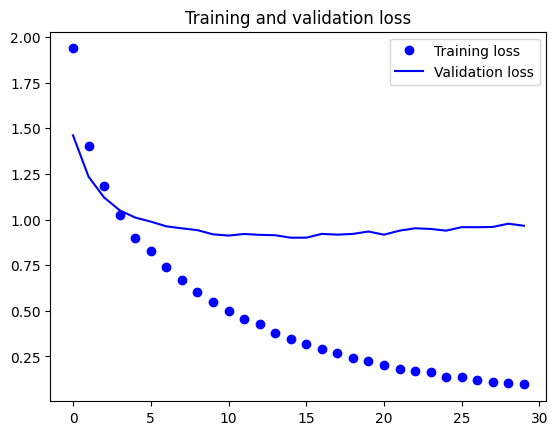

In [ ]:
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# Load the model
model_2 = keras.models.load_model('/content/drive/My Drive/Ngee Ann Poly/Deep Learning/ASG1/Code/Step 5/model_2.tf')

evaluation_results = model_2.evaluate(test_features, test_labels)

print("Test Loss:", evaluation_results[0])
print("Test Accuracy:", evaluation_results[1])

16/16 [==============================] - 0s 8ms/step - loss: 0.9881 - acc: 0.6940
Test Loss: 0.988103449344635
Test Accuracy: 0.6940000057220459


In [ ]:
predictions = model_2.predict(test_features)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(test_labels, axis=1)

class_report = classification_report(true_labels, predicted_labels)
print("Classification Report:")
print(class_report)

16/16 [==============================] - 0s 3ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.56      0.62        50
           1       0.86      0.76      0.81        50
           2       0.61      0.66      0.63        50
           3       0.57      0.74      0.64        50
           4       0.83      0.76      0.79        50
           5       0.65      0.74      0.69        50
           6       0.65      0.48      0.55        50
           7       0.63      0.74      0.68        50
           8       0.61      0.60      0.61        50
           9       0.94      0.90      0.92        50

    accuracy                           0.69       500
   macro avg       0.70      0.69      0.69       500
weighted avg       0.70      0.69      0.69       500



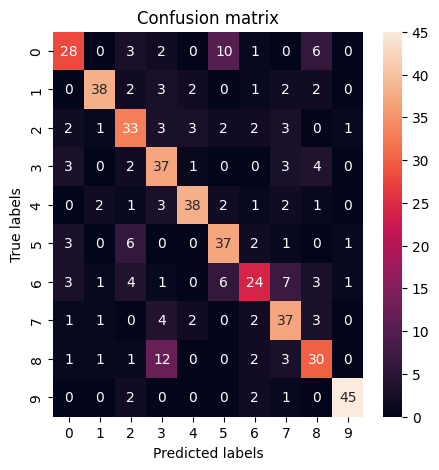

In [ ]:
confusion_matrix_2 = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(5,5))
sns.heatmap(confusion_matrix_2, annot=True, fmt='d')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion matrix')
plt.show()

## 1.2 Feature extraction with data augmentation

In [ ]:
conv_base_1.trainable = False

model_3 = models.Sequential()
model_3.add(conv_base_1)
model_3.add(layers.Flatten())
model_3.add(layers.Dense(256, activation='relu'))
model_3.add(layers.Dense(10, activation='softmax'))

model_3.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_16 (Dense)            (None, 256)               6422784   
                                                                 
 dense_17 (Dense)            (None, 10)                2570      
                                                                 
Total params: 21140042 (80.64 MB)
Trainable params: 6425354 (24.51 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [6]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

validation_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(img_size, img_size),
        batch_size=25,
        class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(img_size, img_size),
        batch_size=25,
        class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    batch_size=25,
    class_mode='categorical')

Found 7500 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
Found 500 images belonging to 10 classes.


In [ ]:
model_3.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.Adam(learning_rate=2e-5),
    metrics=['acc']
)

In [ ]:
checkpoint_filepath = '/content/drive/My Drive/Ngee Ann Poly/Deep Learning/ASG1/Code/Step 5/model_3.tf'
model_checkpoint = ModelCheckpoint(
    checkpoint_filepath,
    monitor='val_acc',
    save_best_only=True,
    mode='max',
    verbose=1
)

In [ ]:
history = model_3.fit(
    train_generator,
    steps_per_epoch=300,
    epochs = 30,
    validation_data=validation_generator,
    validation_steps=80,
    callbacks=[model_checkpoint],
    verbose=1
)

Epoch 1/30
300/300 [==============================] - ETA: 0s - loss: 1.7732 - acc: 0.3851
Epoch 1: val_acc improved from -inf to 0.56150, saving model to /content/drive/My Drive/Ngee Ann Poly/Deep Learning/ASG1/Code/Step 5/model_3.tf
300/300 [==============================] - 139s 460ms/step - loss: 1.7732 - acc: 0.3851 - val_loss: 1.3056 - val_acc: 0.5615
Epoch 2/30
300/300 [==============================] - ETA: 0s - loss: 1.3580 - acc: 0.5335
Epoch 2: val_acc improved from 0.56150 to 0.59050, saving model to /content/drive/My Drive/Ngee Ann Poly/Deep Learning/ASG1/Code/Step 5/model_3.tf
300/300 [==============================] - 139s 463ms/step - loss: 1.3580 - acc: 0.5335 - val_loss: 1.1609 - val_acc: 0.5905
Epoch 3/30
300/300 [==============================] - ETA: 0s - loss: 1.2170 - acc: 0.5891
Epoch 3: val_acc improved from 0.59050 to 0.63400, saving model to /content/drive/My Drive/Ngee Ann Poly/Deep Learning/ASG1/Code/Step 5/model_3.tf
300/300 [==============================

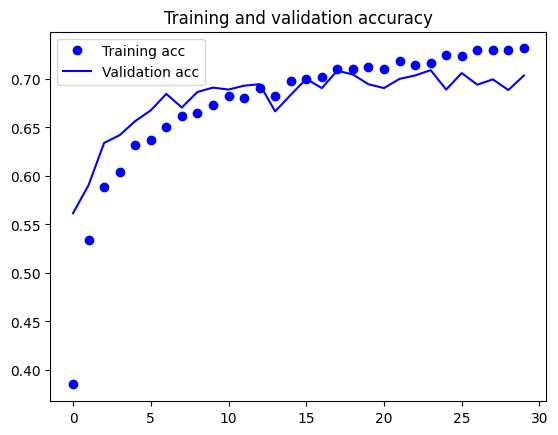

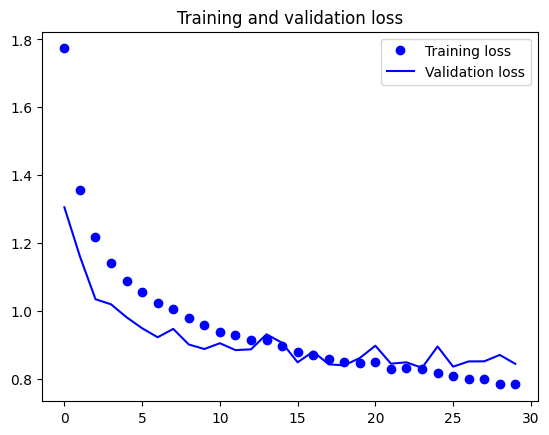

In [ ]:
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
model_3 = keras.models.load_model('/content/drive/My Drive/Ngee Ann Poly/Deep Learning/ASG1/Code/Step 5/model_3.tf')

evaluation_results = model_3.evaluate(test_generator, steps=len(test_generator))

print("Test Loss:", evaluation_results[0])
print("Test Accuracy:", evaluation_results[1])

20/20 [==============================] - 4s 157ms/step - loss: 0.8778 - acc: 0.6700
Test Loss: 0.8777861595153809
Test Accuracy: 0.6700000166893005


In [ ]:
x_test = []
y_test = []

class_labels = {'beet_salad': 0, 'beignets': 1, 'ceviche': 2, 'chocolate_mousse': 3, 'cup_cakes': 4,
                'greek_salad': 5, 'grilled_salmon': 6, 'pancakes': 7, 'panna_cotta': 8, 'spaghetti_bolognese': 9}

for class_folder in sorted(os.listdir(test_dir)):
    class_folder_path = os.path.join(test_dir, class_folder)
    if os.path.isdir(class_folder_path):
        class_label = class_labels[class_folder]

        for image_file in sorted(os.listdir(class_folder_path)):
            image_path = os.path.join(class_folder_path, image_file)
            img = Image.open(image_path)
            img = img.resize((224, 224))
            img_array = np.array(img)
            x_test.append(img_array)
            y_test.append(class_label)

x_test = np.array(x_test)
y_test = np.array(y_test)

x_test = x_test.astype('float32') / 255.0

In [ ]:
predictions = model_3.predict(x_test)
predicted_labels = np.argmax(predictions, axis= 1)
true_labels = test_generator.classes

class_report = classification_report(true_labels, predicted_labels, target_names=test_generator.class_indices.keys())
print("Classification Report:")
print(class_report)

16/16 [==============================] - 6s 121ms/step
Classification Report:
                     precision    recall  f1-score   support

         beet_salad       0.68      0.64      0.66        50
           beignets       0.86      0.72      0.78        50
            ceviche       0.57      0.56      0.57        50
   chocolate_mousse       0.41      0.52      0.46        50
          cup_cakes       0.80      0.82      0.81        50
        greek_salad       0.65      0.82      0.73        50
     grilled_salmon       0.76      0.62      0.68        50
           pancakes       0.70      0.76      0.73        50
        panna_cotta       0.53      0.50      0.52        50
spaghetti_bolognese       0.98      0.84      0.90        50

           accuracy                           0.68       500
          macro avg       0.69      0.68      0.68       500
       weighted avg       0.69      0.68      0.68       500



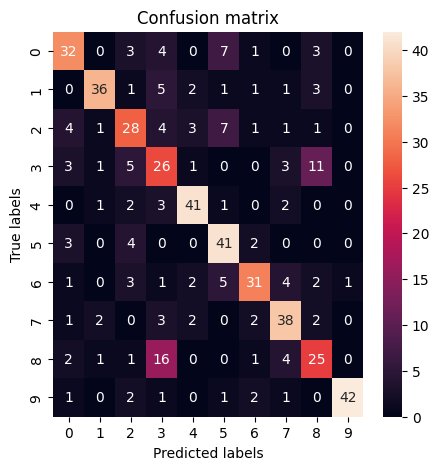

In [ ]:
confusion_matrix_3 = confusion_matrix(y_test, predicted_labels)

plt.figure(figsize=(5,5))
sns.heatmap(confusion_matrix_3, annot=True, fmt='d')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion matrix')
plt.show()

In [ ]:
conv_base_1.trainable = False

model_4 = models.Sequential()
model_4.add(conv_base_1)
model_4.add(layers.GlobalAveragePooling2D())
model_4.add(layers.Dropout(0.25))
model_4.add(layers.Dense(256, activation='relu'))
model_4.add(layers.BatchNormalization())
model_4.add(layers.Dropout(0.1))
model_4.add(layers.Dense(128, activation='relu'))
model_4.add(layers.BatchNormalization())
model_4.add(layers.Dropout(0.1))
model_4.add(layers.Dense(10, activation='softmax'))

model_4.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout_7 (Dropout)         (None, 512)               0         
                                                                 
 dense_18 (Dense)            (None, 256)               131328    
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 dropout_8 (Dropout)         (None, 256)              

In [ ]:
model_4.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.Adam(learning_rate=2e-5),
    metrics=['acc']
)

In [ ]:
checkpoint_filepath = '/content/drive/My Drive/Ngee Ann Poly/Deep Learning/ASG1/Code/Step 5/model_4.tf'
model_checkpoint = ModelCheckpoint(
    checkpoint_filepath,
    monitor='val_acc',
    save_best_only=True,
    mode='max',
    verbose=1
)

In [ ]:
history = model_4.fit(
    train_generator,
    steps_per_epoch=300,
    epochs = 30,
    validation_data=validation_generator,
    validation_steps=80,
    callbacks=[model_checkpoint],
    verbose=1
)

Epoch 1/30
300/300 [==============================] - ETA: 0s - loss: 2.9180 - acc: 0.1077
Epoch 1: val_acc improved from -inf to 0.15150, saving model to /content/drive/My Drive/Ngee Ann Poly/Deep Learning/ASG1/Code/Step 5/model_4.tf
300/300 [==============================] - 141s 458ms/step - loss: 2.9180 - acc: 0.1077 - val_loss: 2.3533 - val_acc: 0.1515
Epoch 2/30
300/300 [==============================] - ETA: 0s - loss: 2.6706 - acc: 0.1440
Epoch 2: val_acc improved from 0.15150 to 0.22050, saving model to /content/drive/My Drive/Ngee Ann Poly/Deep Learning/ASG1/Code/Step 5/model_4.tf
300/300 [==============================] - 138s 460ms/step - loss: 2.6706 - acc: 0.1440 - val_loss: 2.1845 - val_acc: 0.2205
Epoch 3/30
300/300 [==============================] - ETA: 0s - loss: 2.4948 - acc: 0.1696
Epoch 3: val_acc improved from 0.22050 to 0.28900, saving model to /content/drive/My Drive/Ngee Ann Poly/Deep Learning/ASG1/Code/Step 5/model_4.tf
300/300 [==============================

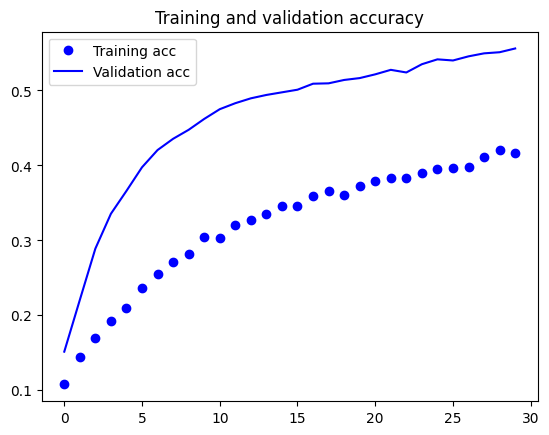

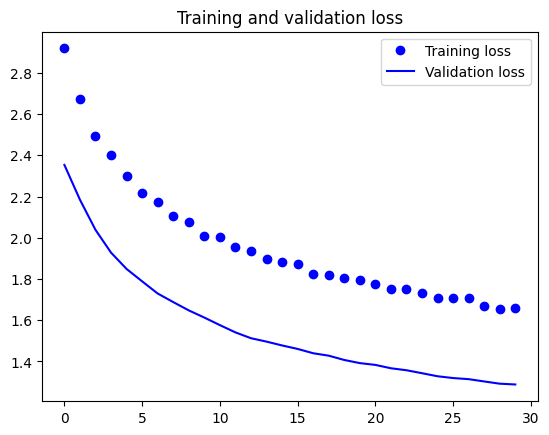

In [ ]:
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
model_4 = keras.models.load_model('/content/drive/My Drive/Ngee Ann Poly/Deep Learning/ASG1/Code/Step 5/model_4.tf')

evaluation_results = model_4.evaluate(test_generator, steps=len(test_generator))

print("Test Loss:", evaluation_results[0])
print("Test Accuracy:", evaluation_results[1])

20/20 [==============================] - 3s 118ms/step - loss: 1.3168 - acc: 0.5580
Test Loss: 1.3168137073516846
Test Accuracy: 0.5580000281333923


In [ ]:
predictions = model_4.predict(x_test)
predicted_labels = np.argmax(predictions, axis= 1)
true_labels = test_generator.classes

class_report = classification_report(true_labels, predicted_labels, target_names=test_generator.class_indices.keys())
print("Classification Report:")
print(class_report)

16/16 [==============================] - 2s 130ms/step
Classification Report:
                     precision    recall  f1-score   support

         beet_salad       0.49      0.68      0.57        50
           beignets       0.70      0.60      0.65        50
            ceviche       1.00      0.08      0.15        50
   chocolate_mousse       0.44      0.32      0.37        50
          cup_cakes       0.72      0.66      0.69        50
        greek_salad       0.46      0.66      0.54        50
     grilled_salmon       0.61      0.44      0.51        50
           pancakes       0.60      0.62      0.61        50
        panna_cotta       0.38      0.60      0.47        50
spaghetti_bolognese       0.71      0.90      0.80        50

           accuracy                           0.56       500
          macro avg       0.61      0.56      0.53       500
       weighted avg       0.61      0.56      0.53       500



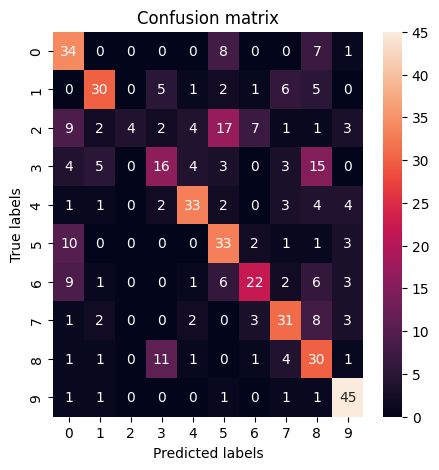

In [ ]:
confusion_matrix_4 = confusion_matrix(y_test, predicted_labels)

plt.figure(figsize=(5,5))
sns.heatmap(confusion_matrix_4, annot=True, fmt='d')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion matrix')
plt.show()

In [3]:
conv_base_2 = keras.applications.mobilenet_v2.MobileNetV2(weights='imagenet',
                                                             include_top=False,
                                                             input_shape=(img_size, img_size, 3))


9406464/9406464 [==============================] - 5s 1us/step


In [ ]:
conv_base_2.trainable = False

model_5 = models.Sequential()
model_5.add(conv_base)
model_5.add(layers.Flatten())
model_5.add(layers.Dense(256, activation='relu'))
model_5.add(layers.Dense(10, activation='softmax'))

model_5.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dense_21 (Dense)            (None, 256)               6422784   
                                                                 
 dense_22 (Dense)            (None, 10)                2570      
                                                                 
Total params: 21140042 (80.64 MB)
Trainable params: 6425354 (24.51 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [ ]:
model_5.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.Adam(learning_rate=2e-5),
    metrics=['acc']
)

In [ ]:
checkpoint_filepath = '/content/drive/My Drive/Ngee Ann Poly/Deep Learning/ASG1/Code/Step 5/model_5.tf'
model_checkpoint = ModelCheckpoint(
    checkpoint_filepath,
    monitor='val_acc',
    save_best_only=True,
    mode='max',
    verbose=1
)

In [ ]:
history = model_5.fit(
    train_generator,
    steps_per_epoch=300,
    epochs = 30,
    validation_data=validation_generator,
    validation_steps=80,
    callbacks=[model_checkpoint],
    verbose=1
)

Epoch 1/30
300/300 [==============================] - ETA: 0s - loss: 1.7862 - acc: 0.3803
Epoch 1: val_acc improved from -inf to 0.52350, saving model to /content/drive/My Drive/Ngee Ann Poly/Deep Learning/ASG1/Code/Step 5/model_5.tf
300/300 [==============================] - 137s 452ms/step - loss: 1.7862 - acc: 0.3803 - val_loss: 1.4177 - val_acc: 0.5235
Epoch 2/30
300/300 [==============================] - ETA: 0s - loss: 1.3739 - acc: 0.5361
Epoch 2: val_acc improved from 0.52350 to 0.61850, saving model to /content/drive/My Drive/Ngee Ann Poly/Deep Learning/ASG1/Code/Step 5/model_5.tf
300/300 [==============================] - 140s 468ms/step - loss: 1.3739 - acc: 0.5361 - val_loss: 1.1238 - val_acc: 0.6185
Epoch 3/30
300/300 [==============================] - ETA: 0s - loss: 1.2359 - acc: 0.5784
Epoch 3: val_acc improved from 0.61850 to 0.63800, saving model to /content/drive/My Drive/Ngee Ann Poly/Deep Learning/ASG1/Code/Step 5/model_5.tf
300/300 [==============================

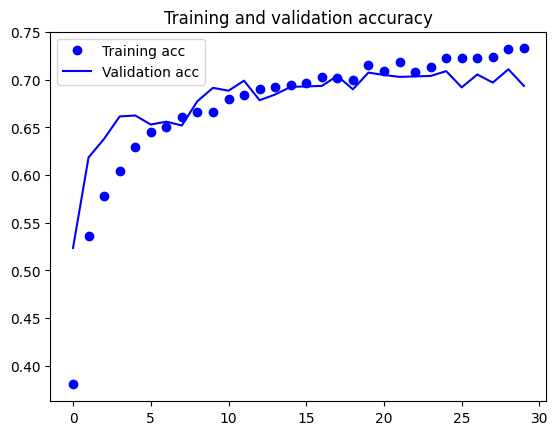

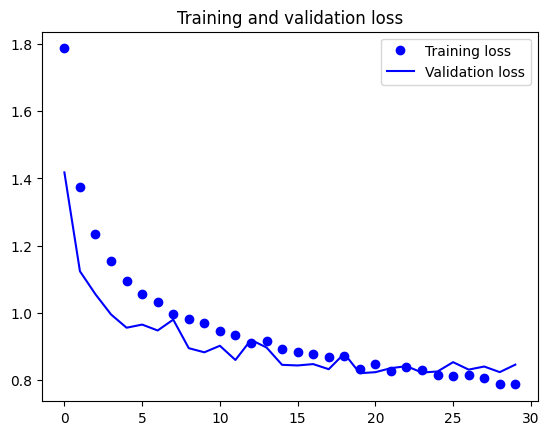

In [ ]:
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
model_5 = keras.models.load_model('/content/drive/My Drive/Ngee Ann Poly/Deep Learning/ASG1/Code/Step 5/model_5.tf')

evaluation_results = model_5.evaluate(test_generator, steps=len(test_generator))

print("Test Loss:", evaluation_results[0])
print("Test Accuracy:", evaluation_results[1])

20/20 [==============================] - 3s 114ms/step - loss: 0.8436 - acc: 0.6980
Test Loss: 0.843561589717865
Test Accuracy: 0.6980000138282776


In [ ]:
predictions = model_5.predict(x_test)
predicted_labels = np.argmax(predictions, axis= 1)
true_labels = test_generator.classes

class_report = classification_report(true_labels, predicted_labels, target_names=test_generator.class_indices.keys())
print("Classification Report:")
print(class_report)

16/16 [==============================] - 2s 127ms/step
Classification Report:
                     precision    recall  f1-score   support

         beet_salad       0.59      0.76      0.67        50
           beignets       0.83      0.78      0.80        50
            ceviche       0.59      0.52      0.55        50
   chocolate_mousse       0.44      0.58      0.50        50
          cup_cakes       0.84      0.76      0.80        50
        greek_salad       0.74      0.80      0.77        50
     grilled_salmon       0.74      0.64      0.69        50
           pancakes       0.87      0.68      0.76        50
        panna_cotta       0.59      0.54      0.56        50
spaghetti_bolognese       0.90      0.94      0.92        50

           accuracy                           0.70       500
          macro avg       0.71      0.70      0.70       500
       weighted avg       0.71      0.70      0.70       500



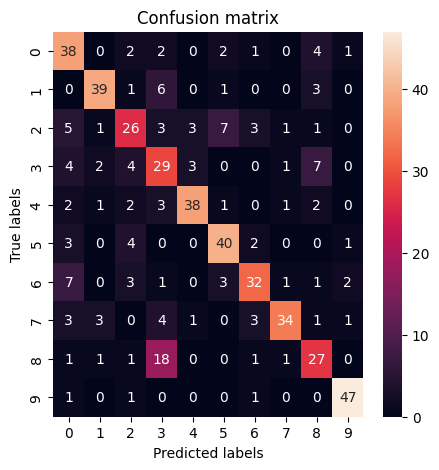

In [ ]:
confusion_matrix_5 = confusion_matrix(y_test, predicted_labels)

plt.figure(figsize=(5,5))
sns.heatmap(confusion_matrix_5, annot=True, fmt='d')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion matrix')
plt.show()

In [ ]:
conv_base_2.trainable = False

model_6 = models.Sequential()
model_6.add(conv_base_2)
model_6.add(layers.GlobalAveragePooling2D())
model_6.add(layers.Dropout(0.25))
model_6.add(layers.Dense(256, activation='relu'))
model_6.add(layers.BatchNormalization())
model_6.add(layers.Dropout(0.1))
model_6.add(layers.Dense(128, activation='relu'))
model_6.add(layers.BatchNormalization())
model_6.add(layers.Dropout(0.1))
model_6.add(layers.Dense(10, activation='softmax'))

model_6.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_10 (Dropout)        (None, 1280)              0         
                                                                 
 dense_23 (Dense)            (None, 256)               327936    
                                                                 
 batch_normalization_2 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                     

In [ ]:
model_6.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.Adam(learning_rate=0.0005),
    metrics=['acc']
)

In [ ]:
checkpoint_filepath = '/content/drive/My Drive/Ngee Ann Poly/Deep Learning/ASG1/Code/Step 5/model_6.tf'
model_checkpoint = ModelCheckpoint(
    checkpoint_filepath,
    monitor='val_acc',
    save_best_only=True,
    mode='max',
    verbose=1
)

In [ ]:
history = model_6.fit(
    train_generator,
    steps_per_epoch=300,
    epochs = 30,
    validation_data=validation_generator,
    validation_steps=80,
    callbacks=[model_checkpoint],
    verbose=1
)

Epoch 1/30
300/300 [==============================] - ETA: 0s - loss: 1.2945 - acc: 0.5685
Epoch 1: val_acc improved from -inf to 0.74250, saving model to /content/drive/My Drive/Ngee Ann Poly/Deep Learning/ASG1/Code/Step 5/model_6.tf


300/300 [==============================] - 150s 479ms/step - loss: 1.2945 - acc: 0.5685 - val_loss: 0.7368 - val_acc: 0.7425
Epoch 2/30
300/300 [==============================] - ETA: 0s - loss: 0.9368 - acc: 0.6767
Epoch 2: val_acc improved from 0.74250 to 0.77450, saving model to /content/drive/My Drive/Ngee Ann Poly/Deep Learning/ASG1/Code/Step 5/model_6.tf


300/300 [==============================] - 150s 501ms/step - loss: 0.9368 - acc: 0.6767 - val_loss: 0.6575 - val_acc: 0.7745
Epoch 3/30
300/300 [==============================] - ETA: 0s - loss: 0.8699 - acc: 0.6983
Epoch 3: val_acc improved from 0.77450 to 0.78450, saving model to /content/drive/My Drive/Ngee Ann Poly/Deep Learning/ASG1/Code/Step 5/model_6.tf
300/300 [==============================] - 146s 486ms/step - loss: 0.8699 - acc: 0.6983 - val_loss: 0.6303 - val_acc: 0.7845
Epoch 4/30
300/300 [==============================] - ETA: 0s - loss: 0.8000 - acc: 0.7244
Epoch 4: val_acc improved from 0.78450 to 0.79150, saving model to /content/drive/My Drive/Ngee Ann Poly/Deep Learning/ASG1/Code/Step 5/model_6.tf
300/300 [==============================] - 149s 496ms/step - loss: 0.8000 - acc: 0.7244 - val_loss: 0.6036 - val_acc: 0.7915
Epoch 5/30
300/300 [==============================] - ETA: 0s - loss: 0.7726 - acc: 0.7321
Epoch 5: val_acc did not improve from 0.79150
300/300 [===

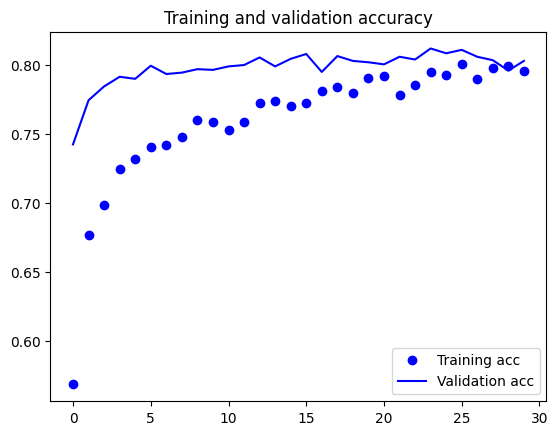

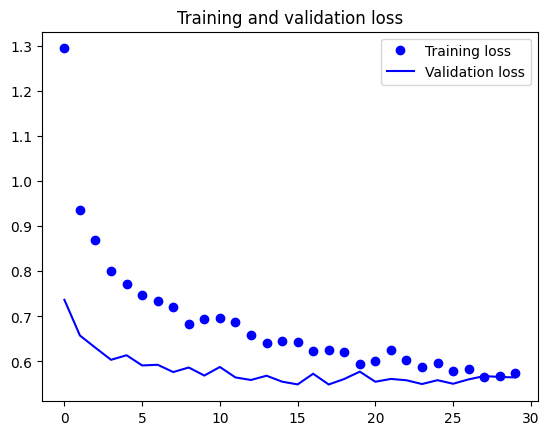

In [ ]:
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
model_6 = keras.models.load_model('/content/drive/My Drive/Ngee Ann Poly/Deep Learning/ASG1/Code/Step 5/model_6.tf')

evaluation_results = model_6.evaluate(test_generator, steps=len(test_generator))

print("Test Loss:", evaluation_results[0])
print("Test Accuracy:", evaluation_results[1])

20/20 [==============================] - 3s 102ms/step - loss: 0.5861 - acc: 0.8120
Test Loss: 0.5860580205917358
Test Accuracy: 0.8119999766349792


In [ ]:
predictions = model_6.predict(x_test)
predicted_labels = np.argmax(predictions, axis= 1)
true_labels = test_generator.classes

class_report = classification_report(true_labels, predicted_labels, target_names=test_generator.class_indices.keys())
print("Classification Report:")
print(class_report)

16/16 [==============================] - 2s 66ms/step
Classification Report:
                     precision    recall  f1-score   support

         beet_salad       0.80      0.70      0.74        50
           beignets       0.94      0.68      0.79        50
            ceviche       0.70      0.78      0.74        50
   chocolate_mousse       0.57      0.68      0.62        50
          cup_cakes       0.94      0.94      0.94        50
        greek_salad       0.82      0.80      0.81        50
     grilled_salmon       0.87      0.82      0.85        50
           pancakes       0.75      0.84      0.79        50
        panna_cotta       0.79      0.74      0.76        50
spaghetti_bolognese       0.91      1.00      0.95        50

           accuracy                           0.80       500
          macro avg       0.81      0.80      0.80       500
       weighted avg       0.81      0.80      0.80       500



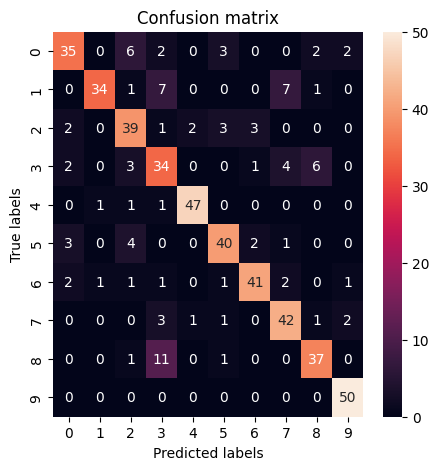

In [ ]:
confusion_matrix_6 = confusion_matrix(y_test, predicted_labels)

plt.figure(figsize=(5,5))
sns.heatmap(confusion_matrix_6, annot=True, fmt='d')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion matrix')
plt.show()

## 1.3 Fine Tuning

In [ ]:
conv_base_2.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_2[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[

In [ ]:
conv_base_2.trainable = True

set_trainable = False
for layer in conv_base_2.layers:
    if layer.name == 'Conv_1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

model_7 = models.Sequential()
model_7.add(conv_base_2)
model_7.add(layers.GlobalAveragePooling2D())
model_7.add(layers.Dropout(0.25))
model_7.add(layers.Dense(256, activation='relu'))
model_7.add(layers.BatchNormalization())
model_7.add(layers.Dropout(0.1))
model_7.add(layers.Dense(128, activation='relu'))
model_7.add(layers.BatchNormalization())
model_7.add(layers.Dropout(0.1))
model_7.add(layers.Dense(10, activation='softmax'))

model_7.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                        

In [ ]:
model_7.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.Adam(learning_rate=0.0005),
    metrics=['acc']
)

In [ ]:
checkpoint_filepath = '/content/drive/My Drive/Ngee Ann Poly/Deep Learning/ASG1/Code/Step 5/model_7.tf'
model_checkpoint = ModelCheckpoint(
    checkpoint_filepath,
    monitor='val_acc',
    save_best_only=True,
    mode='max',
    verbose=1
)

In [ ]:
history = model_7.fit(
    train_generator,
    steps_per_epoch=300,
    epochs = 30,
    validation_data=validation_generator,
    validation_steps=80,
    callbacks=[model_checkpoint],
    verbose=1
)

Epoch 1/30
300/300 [==============================] - ETA: 0s - loss: 1.1345 - acc: 0.6207
Epoch 1: val_acc improved from -inf to 0.72300, saving model to /content/drive/My Drive/Ngee Ann Poly/Deep Learning/ASG1/Code/Step 5/model_7.tf


300/300 [==============================] - 3314s 11s/step - loss: 1.1345 - acc: 0.6207 - val_loss: 0.8221 - val_acc: 0.7230
Epoch 2/30
300/300 [==============================] - ETA: 0s - loss: 0.7987 - acc: 0.7252
Epoch 2: val_acc improved from 0.72300 to 0.75650, saving model to /content/drive/My Drive/Ngee Ann Poly/Deep Learning/ASG1/Code/Step 5/model_7.tf


300/300 [==============================] - 158s 528ms/step - loss: 0.7987 - acc: 0.7252 - val_loss: 0.7377 - val_acc: 0.7565
Epoch 3/30
300/300 [==============================] - ETA: 0s - loss: 0.7202 - acc: 0.7532
Epoch 3: val_acc improved from 0.75650 to 0.77250, saving model to /content/drive/My Drive/Ngee Ann Poly/Deep Learning/ASG1/Code/Step 5/model_7.tf
300/300 [==============================] - 155s 516ms/step - loss: 0.7202 - acc: 0.7532 - val_loss: 0.6280 - val_acc: 0.7725
Epoch 4/30
300/300 [==============================] - ETA: 0s - loss: 0.6452 - acc: 0.7767
Epoch 4: val_acc improved from 0.77250 to 0.79150, saving model to /content/drive/My Drive/Ngee Ann Poly/Deep Learning/ASG1/Code/Step 5/model_7.tf
300/300 [==============================] - 156s 519ms/step - loss: 0.6452 - acc: 0.7767 - val_loss: 0.6249 - val_acc: 0.7915
Epoch 5/30
300/300 [==============================] - ETA: 0s - loss: 0.5986 - acc: 0.7925
Epoch 5: val_acc improved from 0.79150 to 0.80100, saving 

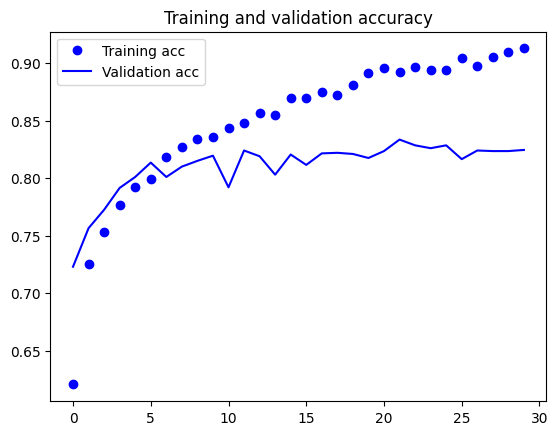

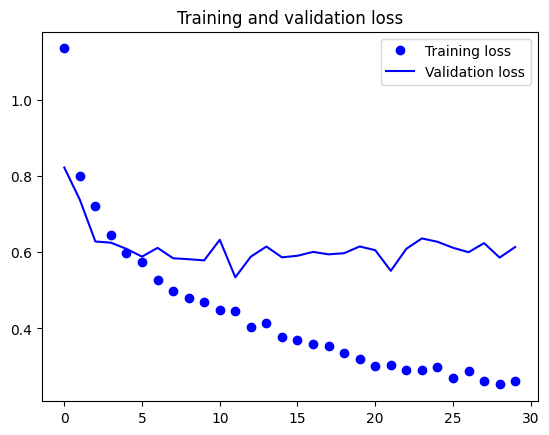

In [ ]:
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
model_7 = keras.models.load_model('/content/drive/My Drive/Ngee Ann Poly/Deep Learning/ASG1/Code/Step 5/model_7.tf')

evaluation_results = model_7.evaluate(test_generator, steps=len(test_generator))

print("Test Loss:", evaluation_results[0])
print("Test Accuracy:", evaluation_results[1])

20/20 [==============================] - 174s 9s/step - loss: 0.6175 - acc: 0.7980
Test Loss: 0.6174952983856201
Test Accuracy: 0.7979999780654907


In [ ]:
predictions = model_7.predict(x_test)
predicted_labels = np.argmax(predictions, axis= 1)
true_labels = test_generator.classes

class_report = classification_report(true_labels, predicted_labels, target_names=test_generator.class_indices.keys())
print("Classification Report:")
print(class_report)

16/16 [==============================] - 3s 73ms/step
Classification Report:
                     precision    recall  f1-score   support

         beet_salad       0.73      0.72      0.73        50
           beignets       0.93      0.80      0.86        50
            ceviche       0.79      0.82      0.80        50
   chocolate_mousse       0.58      0.72      0.64        50
          cup_cakes       0.94      0.88      0.91        50
        greek_salad       0.74      0.84      0.79        50
     grilled_salmon       0.91      0.78      0.84        50
           pancakes       0.76      0.82      0.79        50
        panna_cotta       0.78      0.70      0.74        50
spaghetti_bolognese       1.00      0.96      0.98        50

           accuracy                           0.80       500
          macro avg       0.82      0.80      0.81       500
       weighted avg       0.82      0.80      0.81       500



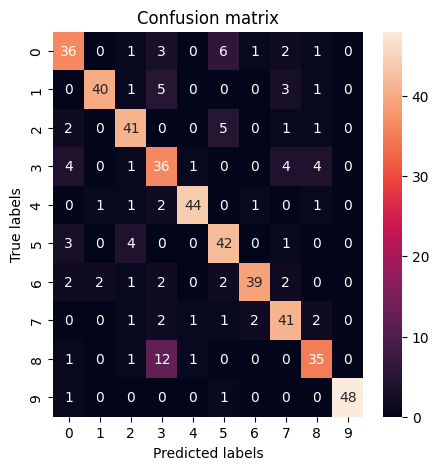

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix_7 = confusion_matrix(y_test, predicted_labels)

plt.figure(figsize=(5,5))
sns.heatmap(confusion_matrix_7, annot=True, fmt='d')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion matrix')
plt.show()

In [ ]:
conv_base_2.trainable = True

set_trainable = False
for layer in conv_base_2.layers:
    if layer.name == 'block_16_project_BN':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

model_8 = models.Sequential()
model_8.add(conv_base_2)
model_8.add(layers.GlobalAveragePooling2D())
model_8.add(layers.Dropout(0.25))
model_8.add(layers.Dense(256, activation='relu'))
model_8.add(layers.BatchNormalization())
model_8.add(layers.Dropout(0.1))
model_8.add(layers.Dense(128, activation='relu'))
model_8.add(layers.BatchNormalization())
model_8.add(layers.Dropout(0.1))
model_8.add(layers.Dense(10, activation='softmax'))

model_8.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_2  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_6 (Dropout)         (None, 1280)              0         
                                                                 
 dense_6 (Dense)             (None, 256)               327936    
                                                                 
 batch_normalization_4 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                      

In [ ]:
model_8.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.Adam(learning_rate=0.0005),
    metrics=['acc']
)

In [ ]:
checkpoint_filepath = '/content/drive/My Drive/Ngee Ann Poly/Deep Learning/ASG1/Code/Step 5/model_8.tf'
model_checkpoint = ModelCheckpoint(
    checkpoint_filepath,
    monitor='val_acc',
    save_best_only=True,
    mode='max',
    verbose=1
)

In [ ]:
history = model_8.fit(
    train_generator,
    steps_per_epoch=300,
    epochs = 30,
    validation_data=validation_generator,
    validation_steps=80,
    callbacks=[model_checkpoint],
    verbose=1
)

Epoch 1/30
300/300 [==============================] - ETA: 0s - loss: 0.6486 - acc: 0.7864
Epoch 1: val_acc improved from -inf to 0.79350, saving model to /content/drive/My Drive/Ngee Ann Poly/Deep Learning/ASG1/Code/Step 5/model_8.tf
300/300 [==============================] - 154s 495ms/step - loss: 0.6486 - acc: 0.7864 - val_loss: 0.6931 - val_acc: 0.7935
Epoch 2/30
300/300 [==============================] - ETA: 0s - loss: 0.3881 - acc: 0.8685
Epoch 2: val_acc improved from 0.79350 to 0.81350, saving model to /content/drive/My Drive/Ngee Ann Poly/Deep Learning/ASG1/Code/Step 5/model_8.tf
300/300 [==============================] - 148s 494ms/step - loss: 0.3881 - acc: 0.8685 - val_loss: 0.6321 - val_acc: 0.8135
Epoch 3/30
300/300 [==============================] - ETA: 0s - loss: 0.3369 - acc: 0.8843
Epoch 3: val_acc improved from 0.81350 to 0.82200, saving model to /content/drive/My Drive/Ngee Ann Poly/Deep Learning/ASG1/Code/Step 5/model_8.tf
300/300 [==============================

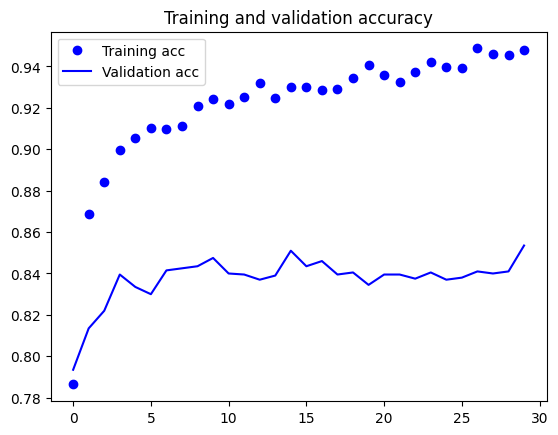

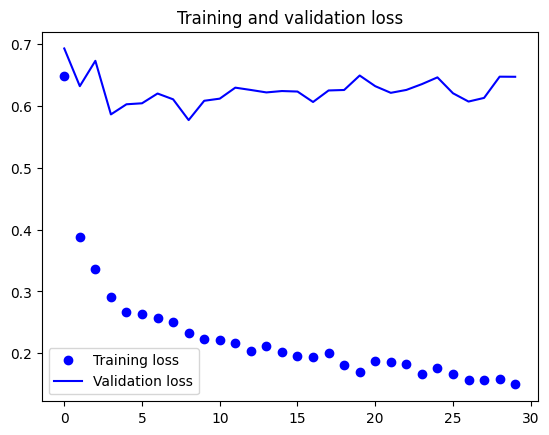

In [ ]:
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [7]:
model_8 = keras.models.load_model('/content/drive/My Drive/Ngee Ann Poly/Deep Learning/ASG1/Code/Step 5/model_8.tf')

evaluation_results = model_8.evaluate(test_generator, steps=len(test_generator))

print("Test Loss:", evaluation_results[0])
print("Test Accuracy:", evaluation_results[1])

20/20 [==============================] - 17s 758ms/step - loss: 0.6233 - acc: 0.8320
Test Loss: 0.6233281493186951
Test Accuracy: 0.8320000171661377


In [ ]:
predictions = model_8.predict(x_test)
predicted_labels = np.argmax(predictions, axis= 1)
true_labels = test_generator.classes

class_report = classification_report(true_labels, predicted_labels, target_names=test_generator.class_indices.keys())
print("Classification Report:")
print(class_report)

16/16 [==============================] - 2s 52ms/step
Classification Report:
                     precision    recall  f1-score   support

         beet_salad       0.88      0.84      0.86        50
           beignets       0.87      0.80      0.83        50
            ceviche       0.72      0.84      0.78        50
   chocolate_mousse       0.64      0.76      0.70        50
          cup_cakes       0.92      0.90      0.91        50
        greek_salad       0.83      0.80      0.82        50
     grilled_salmon       0.91      0.82      0.86        50
           pancakes       0.95      0.82      0.88        50
        panna_cotta       0.74      0.78      0.76        50
spaghetti_bolognese       0.96      0.98      0.97        50

           accuracy                           0.83       500
          macro avg       0.84      0.83      0.84       500
       weighted avg       0.84      0.83      0.84       500



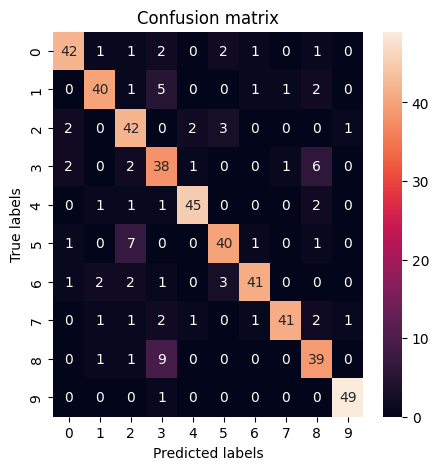

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix_8 = confusion_matrix(y_test, predicted_labels)

plt.figure(figsize=(5,5))
sns.heatmap(confusion_matrix_8, annot=True, fmt='d')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion matrix')
plt.show()

In [9]:
# Load the food list (in alphabetical order)
with open('/content/drive/My Drive/Ngee Ann Poly/Deep Learning/ASG1/18.txt', 'r') as f: # the .txt file which contains a list of food assigned to you
    x = f.readlines()
food_list =[]
for item in x:
    food_list.append(item.strip('\n'))
food_list = sorted(food_list) # food_list needs to be sorted alphabetically before feed into prediction() function
print(food_list)

['beet_salad', 'beignets', 'ceviche', 'chocolate_mousse', 'cup_cakes', 'greek_salad', 'grilled_salmon', 'pancakes', 'panna_cotta', 'spaghetti_bolognese']


In [10]:
# Define some related functions for image process and model prediction
from tensorflow.keras.preprocessing.image import load_img, img_to_array
def image_process(img):
    image = load_img(img, target_size =(img_size, img_size))
    image_array = img_to_array(image)/255
    return image_array

import pandas as pd
def prediction(model, img_array, items_l):
    prob = model.predict(img_array.reshape(1,img_size,img_size,3))
    pro_df = pd.DataFrame(prob, columns = items_l)
    result = items_l[np.argmax(prob)]
    return pro_df, result

In [11]:
# Define some related functions for image process and model prediction
from tensorflow.keras.preprocessing.image import load_img, img_to_array
def image_process(img):
    image = load_img(img, target_size =(img_size, img_size))
    image_array = img_to_array(image)/255
    return image_array

import pandas as pd
def prediction(model, img_array, items_l):
    prob = model.predict(img_array.reshape(1,img_size,img_size,3))
    pro_df = pd.DataFrame(prob, columns = items_l)
    result = items_l[np.argmax(prob)]
    return pro_df, result

1/1 [==============================] - 0s 59ms/step


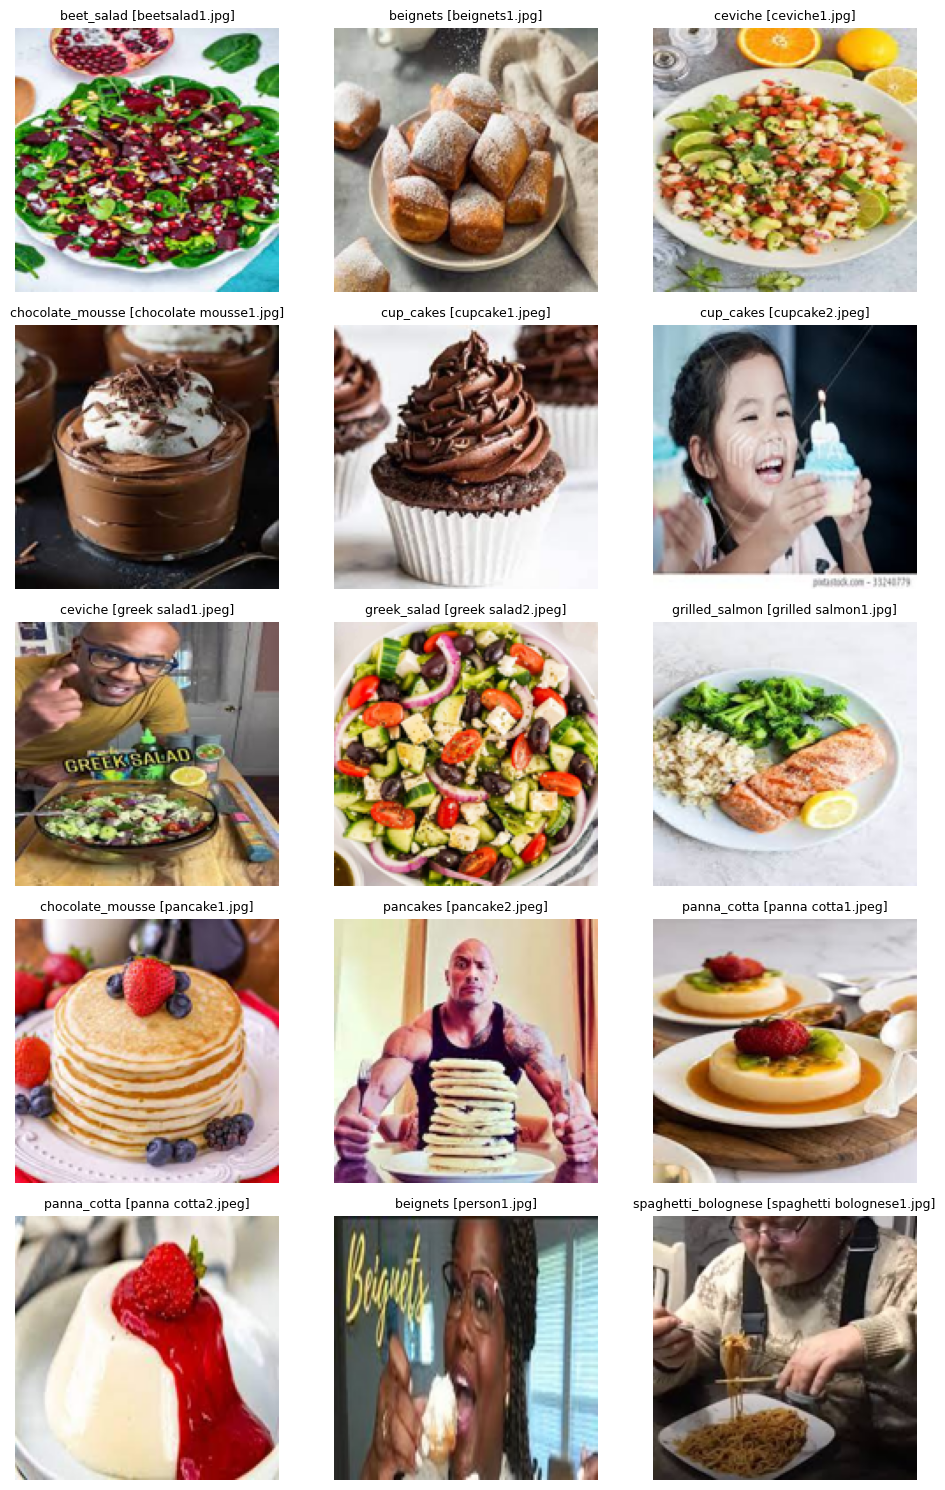

In [26]:
online_images_dir = '/content/drive/My Drive/Ngee Ann Poly/Deep Learning/ASG1/Online Images'
image_files = os.listdir(online_images_dir)


num_images = len(image_files)
images_per_row = 3
num_rows = (num_images + images_per_row - 1) // images_per_row

fig, axes = plt.subplots(num_rows, images_per_row, figsize=(10, 3 * num_rows))

for i, image_file in enumerate(image_files):
    img_path = os.path.join(online_images_dir, image_file)
    ax = axes[i // images_per_row, i % images_per_row]
    ax.axis('off')
    raw_img = Image.open(img_path)
    display_img = raw_img.resize((150,150))
    img_array = image_process(img_path)
    prob_df, result = prediction(model_8, img_array, food_list)
    ax.imshow(display_img)
    ax.set_title(f"{result} [{image_file}]", fontsize=9)

if num_images % images_per_row != 0:
    for i in range(num_images % images_per_row, images_per_row):
        fig.delaxes(axes[num_rows - 1, i])

plt.tight_layout()
plt.show()